In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Indicamos los pasos de tiempo pasados que se utilizaran como recuerdo en el entrenamiento del modelo LSTM
# 7 porque tomaremos datos semanales para entrenar el modelo
TIME_STEP = 7

In [2]:
# Cargamos los datos de temperatura máxima

df_temp_max = pd.read_csv("../Tablas/datos_temp_max_serie.csv")
df_temp_max

,Fecha,"""Temperatura Máxima"""
0,2017-12-02,28.72
1,2017-12-03,27.01
2,2017-12-04,20.49
3,2017-12-05,12.99
4,2017-12-06,24.83
...,...,...
2673,2025-03-28,23.26
2674,2025-03-29,21.10
2675,2025-03-30,20.30
2676,2025-03-31,22.65


In [3]:
# Transformamos la columna "Fecha" a datetime y la situamos en el indice

df_temp_max['Fecha'] = pd.to_datetime(df_temp_max['Fecha'])
df_temp_max.set_index('Fecha',inplace=True)
df_temp_max.head()

,"""Temperatura Máxima"""
Fecha,
2017-12-02,28.72
2017-12-03,27.01
2017-12-04,20.49
2017-12-05,12.99
2017-12-06,24.83


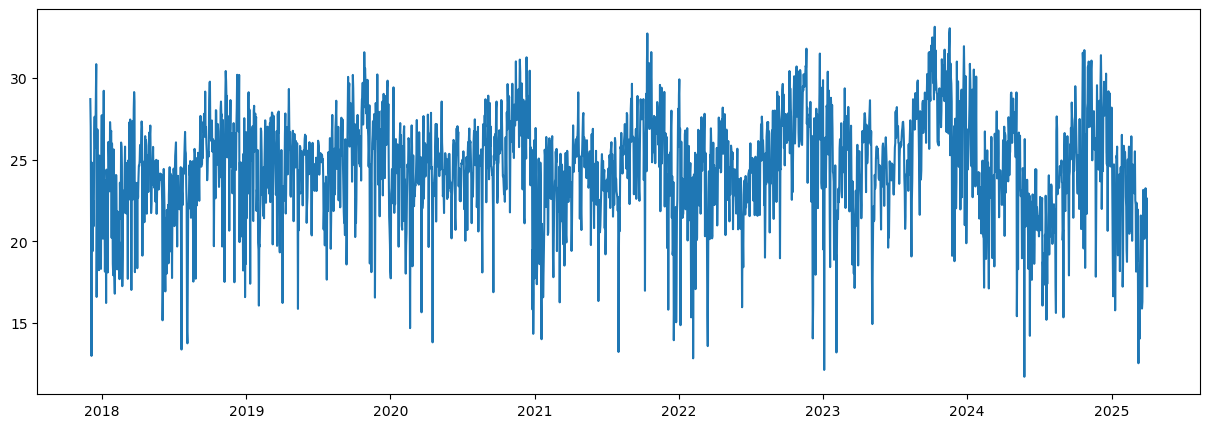

In [4]:
# Observamos el comportamiento de la temperatura máxima segun los datos

plt.figure(figsize=(15,5))
plt.plot(df_temp_max)
plt.show()

### Division de datos

In [5]:
#Obtenemos la lista de valores de temperatura máxima

temp_arr = df_temp_max.filter(['"Temperatura Máxima"'])
#Seleccionamos de la lista solo los valores de la temperatura máxima
temp_datos = temp_arr.values
#Definimos el limite o el tamaño de datos que se utilizaran para entrenamiento (70%)
train_temp_tam = int(np.ceil(len(temp_datos) * 0.7))
#Definimos el limite o el tamaño de datos que se utilizaran para la prueba y validación (20% y 10%)
# 0% entrenamiento 70% prueba 90% validacion 100%
val_tam = int(np.ceil(len(temp_datos) * 0.9))

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
#Escalamos los datos con Min-max

sc = MinMaxScaler()
sc_df_temp = sc.fit_transform(temp_datos)

In [8]:
# Seleccionamos hasta el 70% de los datos para el entrenamiento

train_df_temp = sc_df_temp[:train_temp_tam]

In [9]:
# Creamos la dimension 3d de datos para utilizarlo en la red LSTM (window)

X_train, y_train = [], []

for i in range(TIME_STEP, len(train_df_temp)):
    X_train.append(train_df_temp[i-TIME_STEP:i, 0])
    y_train.append(train_df_temp[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Formando el Window para el modelo LSTM [datos, pasos, cantidad de variables objetivo]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1868, 7, 1)

### Creando el modelo LSTM

In [11]:
from tensorflow import keras

from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.metrics import RootMeanSquaredError
from keras.layers import Input

from keras.callbacks import ModelCheckpoint

In [12]:
# Creamos y configuramos el modelo LSTM con sus capas y parametros correspondientes

modelo_lstm = Sequential()

# Capas LSTM que recordaran datos relevantes de la secuencia
modelo_lstm.add(Input(shape=(X_train.shape[1], 1)))
modelo_lstm.add(LSTM(20, return_sequences=True))
modelo_lstm.add(LSTM(20, return_sequences=False))

#Tranformamos valores < 0 a el valor de 0
modelo_lstm.add(Dense(64, activation='relu'))

#Capa para evitar un sobreajuste del modelo
modelo_lstm.add(Dropout(0.5))

# Capa de salida (1 por que predecimos una variable)
modelo_lstm.add(Dense(1))

modelo_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 20)               │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,449 (25.19 KB)

 Trainable params: 6,449 (25.19 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.optimizers import Adam

In [14]:
# Compilamos el modelo creado y configurado, utilizamos el error MSE y RMSE

modelo_lstm.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mse',
                    metrics=[RootMeanSquaredError()])

In [15]:
#Creamos un "checkpoint" para que guarde el modelo solo si es mejor que alguno ya existente

model_check = ModelCheckpoint('./Mejores_Modelos/modelo_temp_max.keras', monitor='root_mean_squared_error', save_best_only=True)

In [16]:
#Entrenamos el modelo
training = modelo_lstm.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[model_check]) #60

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2058 - root_mean_squared_error: 0.4436
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0360 - root_mean_squared_error: 0.1897
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - root_mean_squared_error: 0.1694
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625

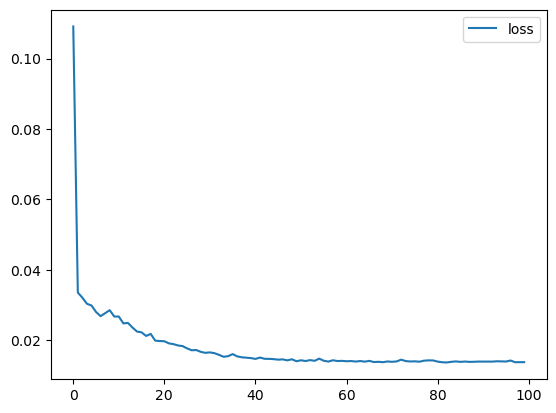

In [17]:
# Graficamos el proceso de entrenamiento del modelo 
plt.plot(training.history['loss'], label='loss')
plt.legend()
plt.show()

In [18]:
## Preparando los datos de prueba seleccionando el 20% de los datos siguientes
test_temp = sc_df_temp[train_temp_tam - TIME_STEP:val_tam]
X_test = []

In [19]:
# Creamos la dimension 3d de datos para utilizarlo en la red LSTM (window)

for i in range(TIME_STEP, len(test_temp)):
    X_test.append(test_temp[i-TIME_STEP:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
# Cargamos el mejor modelo entrenado

mejor_modelo_lstm = keras.models.load_model('./Mejores_Modelos/mejor_modelo_temp_max.keras')
mejor_modelo_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 20)               │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,349 (75.59 KB)

 Trainable params: 6,449 (25.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,900 (50.39 KB)

In [21]:
# Realizamos una prediccion sobre los datos de prueba
y_pred = mejor_modelo_lstm.predict(X_test)

# Reescalamos los datos a su forma original
y_pred_resc = sc.inverse_transform(y_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [22]:
# Obteniendo los datos de prueba (20%)
test_temp = df_temp_max[train_temp_tam:val_tam] #20%

In [23]:
# Realizamos una copia de los datos de prueba
test_temp_cp = test_temp.copy()

In [24]:
# Agregamos la columna de prediccion con lo valores predichos por el modelo
test_temp_cp['Prediccion'] = y_pred_resc

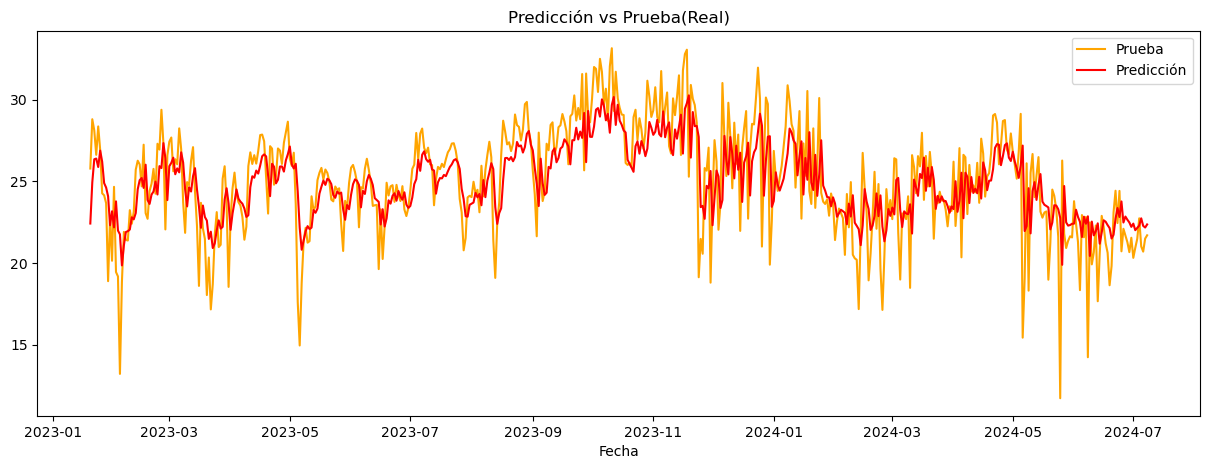

In [25]:
# Graficamos el resultados de las predicciones sobre los datos de prueba

plt.figure(figsize=(15,5))
plt.plot(test_temp_cp['"Temperatura Máxima"'], label="Prueba", color='orange')
plt.plot(test_temp_cp['Prediccion'], label="Predicción", color='red')
plt.title("Predicción vs Prueba(Real)")
plt.xlabel("Fecha")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Obtenemos las metricas generadas

print('Resultados del entrenamiento:')
print('Métrica de MAE:', mean_absolute_error(test_temp_cp['"Temperatura Máxima"'], y_pred_resc).round(4))
print('Métrica de RMSE:', np.sqrt(mean_squared_error(test_temp_cp['"Temperatura Máxima"'], y_pred_resc)).round(4))

Resultados del entrenamiento:
Métrica de MAE: 1.7971
Métrica de RMSE: 2.4222


In [27]:
## Obtenemos los valores de temperatura máxima escalados
val_temp = sc_df_temp[val_tam - TIME_STEP:]

In [28]:
X_val = []

In [29]:
# Creamos el window para pasarlos al modelo LSTM

for i in range(TIME_STEP, len(val_temp)):
    X_val.append(val_temp[i-TIME_STEP:i,0])

X_val = np.array(X_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [30]:
y_pred_val = mejor_modelo_lstm.predict(X_val)
y_pred_resc_val = sc.inverse_transform(y_pred_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [31]:
# Obtenemos el ultimo 10% de los datos (validación)
val_temp = df_temp_max[val_tam:]
val_temp_cp = val_temp.copy()

In [32]:
val_temp_cp['Prediccion'] = y_pred_resc_val

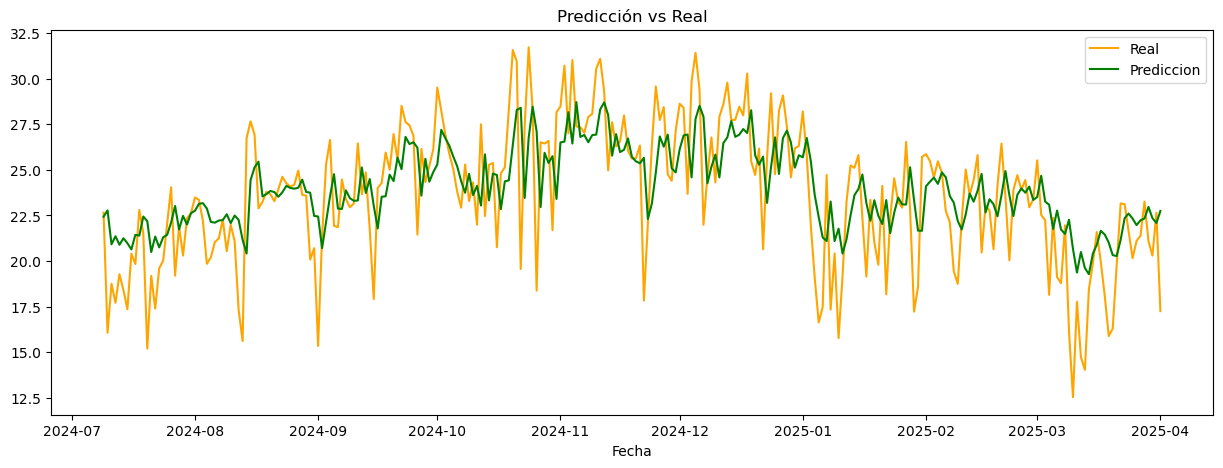

In [33]:
plt.figure(figsize=(15,5))
plt.plot(val_temp_cp['"Temperatura Máxima"'], label="Real", color='orange')
plt.plot(val_temp_cp['Prediccion'], label="Prediccion", color='green')
plt.title("Predicción vs Real")
plt.xlabel("Fecha")
plt.legend()
plt.show()

In [34]:
print('Resultados con datos escalados:')
print('Métrica de MAE:', mean_absolute_error(val_temp_cp['"Temperatura Máxima"'], y_pred_resc_val).round(4))
print('Métrica de RMSE:', np.sqrt(mean_squared_error(val_temp_cp['"Temperatura Máxima"'], y_pred_resc_val)).round(4))

Resultados con datos escalados:
Métrica de MAE: 2.164
Métrica de RMSE: 2.8236


In [35]:
## Exportando resultados de predicciones
#val_temp_cp.to_csv('./predicciones_temp_max_LSTM.csv')